<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Adding a new feature Preferential Attachment

Preferential Attachment One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

In [4]:
#for train dataset
num_followees_s=np.array(df_final_train['num_followees_s'])
num_followees_d=np.array(df_final_train['num_followees_d'])
Preferential_Attachment=[]
for i in range(len(num_followees_s)):
    Preferential_Attachment.append(num_followees_d[i]*num_followees_s[i])
df_final_train['Preferential_Attachment']= Preferential_Attachment
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,8662
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,902
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,35
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,33


In [5]:
#for train dataset
num_followees_s=np.array(df_final_test['num_followees_s'])
num_followees_d=np.array(df_final_test['num_followees_d'])
Preferential_Attachment=[]
for i in range(len(num_followees_s)):
    Preferential_Attachment.append(num_followees_d[i]*num_followees_s[i])
df_final_test['Preferential_Attachment']= Preferential_Attachment
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,...,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,54
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,...,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,19
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,...,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,144
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,...,7.917166e-13,4.020707e-12,2.817657e-13,-2.162590e-11,6.939194e-12,1.879861e-05,4.384816e-12,1.239414e-11,6.483485e-13,340
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,...,1.361574e-13,1.154623e-12,9.656662e-14,-8.742904e-12,7.467370e-12,1.256880e-05,3.636983e-12,3.948463e-12,2.415863e-13,405


In [6]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment'],
      dtype='object')

## Add a new feature called svd_dot

we can calculate svd_dot as Dot product between sourse node svd and destination node svd features

In [8]:
#for train datasets
fu1=df_final_train['svd_u_s_1']
fu2=df_final_train['svd_u_s_2']
fu3=df_final_train['svd_u_s_3']
fu4=df_final_train['svd_u_s_4']
fu5=df_final_train['svd_u_s_5']
fu6=df_final_train['svd_u_s_6']
fv1=df_final_train['svd_v_s_1']
fv2=df_final_train['svd_v_s_2']
fv3=df_final_train['svd_v_s_3']
fv4=df_final_train['svd_v_s_4']
fv5=df_final_train['svd_v_s_5']
fv6=df_final_train['svd_v_s_6']

du1=df_final_train['svd_u_d_1']
du2=df_final_train['svd_u_d_2']
du3=df_final_train['svd_u_d_3']
du4=df_final_train['svd_u_d_4']
du5=df_final_train['svd_u_d_5']
du6=df_final_train['svd_u_d_6']


dv1=df_final_train['svd_v_d_1']
dv2=df_final_train['svd_v_d_2']
dv3=df_final_train['svd_v_d_3']
dv4=df_final_train['svd_v_d_4']
dv5=df_final_train['svd_v_d_5']
dv6=df_final_train['svd_v_d_6']


In [9]:
svd_dot_u=[]
svd_dot_v=[]

for i in range(len(np.array(fu1))):
    fu=[]
    fv=[]
    dv=[]
    du=[]
    fu.append(np.array(fu1[i]))
    fu.append(np.array(fu2[i]))
    fu.append(np.array(fu3[i]))
    fu.append(np.array(fu4[i]))
    fu.append(np.array(fu5[i]))
    fu.append(np.array(fu6[i]))
    
    fv.append(np.array(fv1[i]))
    fv.append(np.array(fv2[i]))
    fv.append(np.array(fv3[i]))
    fv.append(np.array(fv4[i]))
    fv.append(np.array(fv5[i]))
    fv.append(np.array(fv6[i]))
    
    dv.append(np.array(dv1[i]))
    dv.append(np.array(dv2[i]))
    dv.append(np.array(dv3[i]))
    dv.append(np.array(dv4[i]))
    dv.append(np.array(dv5[i]))
    dv.append(np.array(dv6[i]))
    
    du.append(np.array(du1[i]))
    du.append(np.array(du2[i]))
    du.append(np.array(du3[i]))
    du.append(np.array(du4[i]))
    du.append(np.array(du5[i]))
    du.append(np.array(du6[i]))
    svd_dot_u.append(np.dot(fu, du))
    svd_dot_v.append(np.dot(fv, dv))
df_final_train['svd_dot_u']=svd_dot_u
df_final_train['svd_dot_v']=svd_dot_v

In [10]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [11]:
#for test datasets
fu1=df_final_test['svd_u_s_1']
fu2=df_final_test['svd_u_s_2']
fu3=df_final_test['svd_u_s_3']
fu4=df_final_test['svd_u_s_4']
fu5=df_final_test['svd_u_s_5']
fu6=df_final_test['svd_u_s_6']
fv1=df_final_test['svd_v_s_1']
fv2=df_final_test['svd_v_s_2']
fv3=df_final_test['svd_v_s_3']
fv4=df_final_test['svd_v_s_4']
fv5=df_final_test['svd_v_s_5']
fv6=df_final_test['svd_v_s_6']

du1=df_final_test['svd_u_d_1']
du2=df_final_test['svd_u_d_2']
du3=df_final_test['svd_u_d_3']
du4=df_final_test['svd_u_d_4']
du5=df_final_test['svd_u_d_5']
du6=df_final_test['svd_u_d_6']


dv1=df_final_test['svd_v_d_1']
dv2=df_final_test['svd_v_d_2']
dv3=df_final_test['svd_v_d_3']
dv4=df_final_test['svd_v_d_4']
dv5=df_final_test['svd_v_d_5']
dv6=df_final_test['svd_v_d_6']


In [14]:
svd_dot_u=[]
svd_dot_v=[]

for i in range(len(np.array(fu1))):
    fu=[]
    fv=[]
    dv=[]
    du=[]
    fu.append(np.array(fu1[i]))
    fu.append(np.array(fu2[i]))
    fu.append(np.array(fu3[i]))
    fu.append(np.array(fu4[i]))
    fu.append(np.array(fu5[i]))
    fu.append(np.array(fu6[i]))
    
    fv.append(np.array(fv1[i]))
    fv.append(np.array(fv2[i]))
    fv.append(np.array(fv3[i]))
    fv.append(np.array(fv4[i]))
    fv.append(np.array(fv5[i]))
    fv.append(np.array(fv6[i]))
    
    dv.append(np.array(dv1[i]))
    dv.append(np.array(dv2[i]))
    dv.append(np.array(dv3[i]))
    dv.append(np.array(dv4[i]))
    dv.append(np.array(dv5[i]))
    dv.append(np.array(dv6[i]))
    
    du.append(np.array(du1[i]))
    du.append(np.array(du2[i]))
    du.append(np.array(du3[i]))
    du.append(np.array(du4[i]))
    du.append(np.array(du5[i]))
    du.append(np.array(du6[i]))
    svd_dot_u.append(np.dot(fu, du))
    svd_dot_v.append(np.dot(fv, dv))
df_final_test['svd_dot_u']=svd_dot_u
df_final_test['svd_dot_v']=svd_dot_v

In [15]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [16]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [17]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9128093143379071 test Score 0.9003502069404649
Estimators =  50 Train Score 0.919392168567449 test Score 0.914649520927887
Estimators =  100 Train Score 0.9194221575990877 test Score 0.9141969607925446
Estimators =  250 Train Score 0.921380953376105 test Score 0.9165547910723276
Estimators =  450 Train Score 0.9219604521546362 test Score 0.917014800041986


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

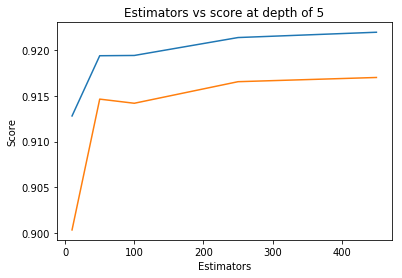

In [18]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.882871311104326 test Score 0.8626248767311236
depth =  9 Train Score 0.9567402987514558 test Score 0.9228852569787576
depth =  11 Train Score 0.9598402575439597 test Score 0.9239729062480219
depth =  15 Train Score 0.9634670268842869 test Score 0.9264284510365751
depth =  20 Train Score 0.9632966096536613 test Score 0.9258386295719516
depth =  35 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  50 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  70 Train Score 0.9632726792981318 test Score 0.926099039919151
depth =  130 Train Score 0.9632726792981318 test Score 0.926099039919151


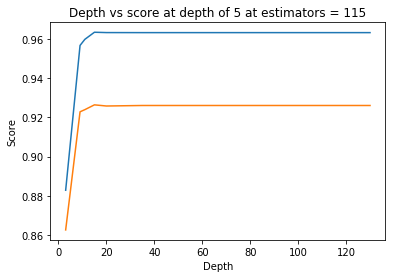

In [19]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [20]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1,

In [21]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [22]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [23]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [24]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.964000691316857
Test f1 score 0.9264547697888764


In [25]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


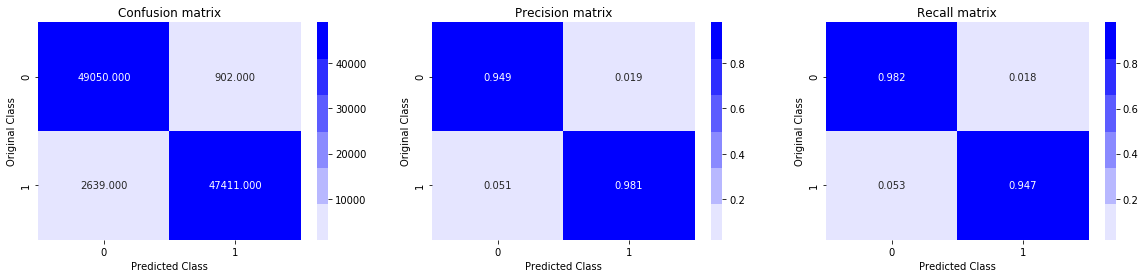

Test confusion_matrix


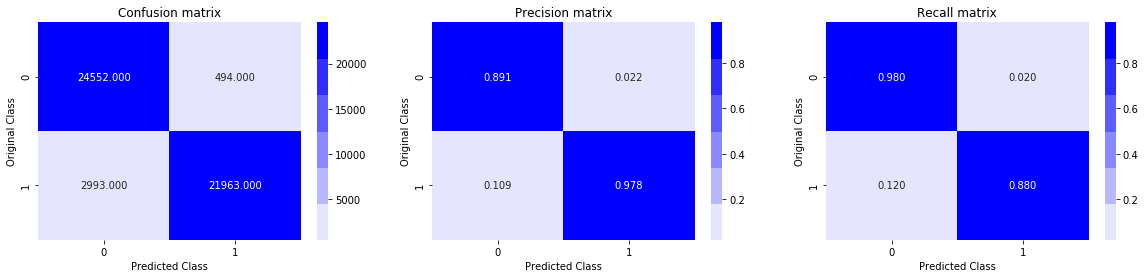

In [26]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

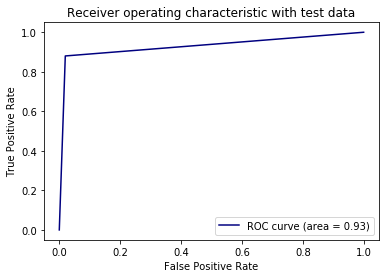

In [27]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

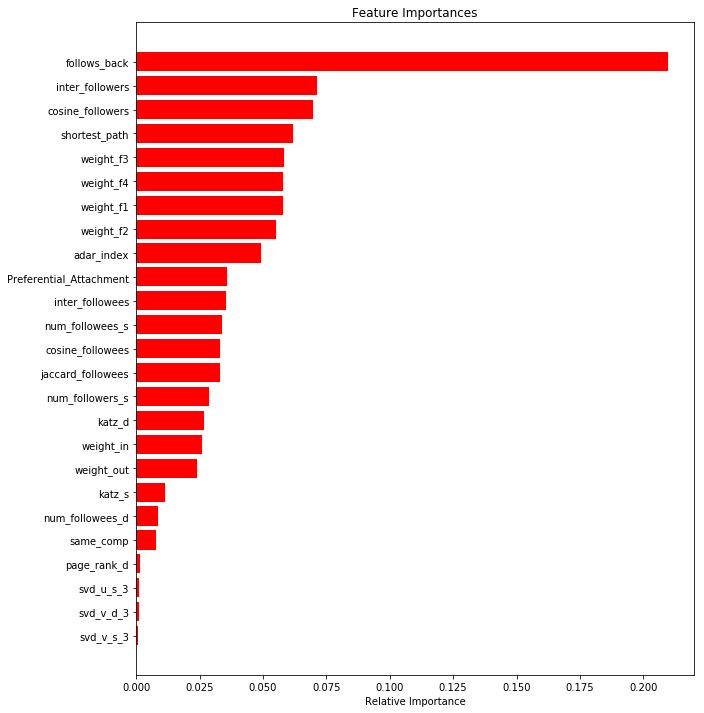

In [28]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost 

In [29]:
import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)}

clf = xgb.XGBClassifier()
#clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distri

In [30]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=110, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [31]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=112,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [33]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9951677260241012
Test f1 score 0.9264074782239219


Train confusion_matrix


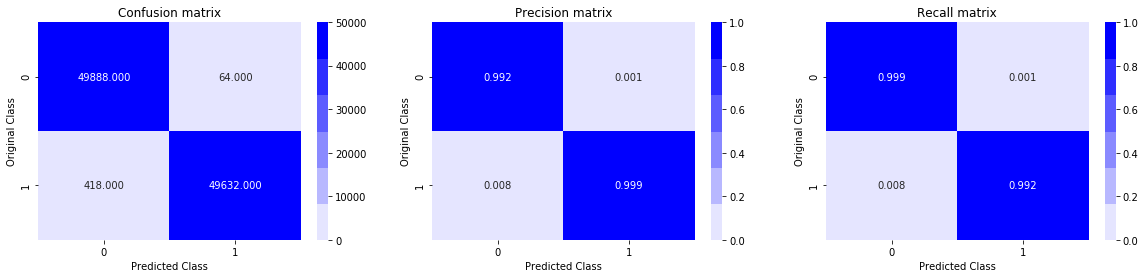

Test confusion_matrix


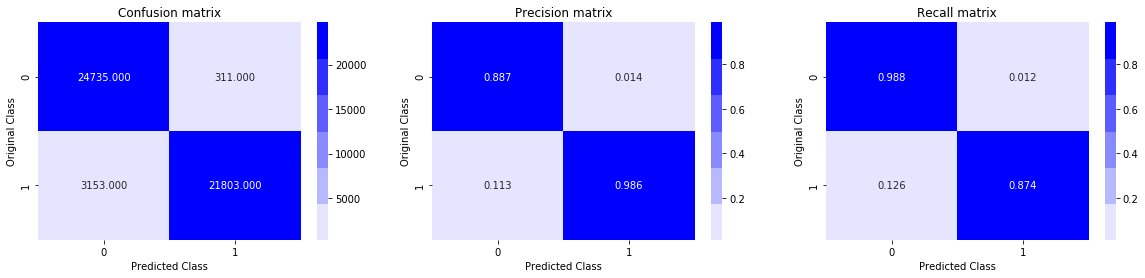

In [34]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

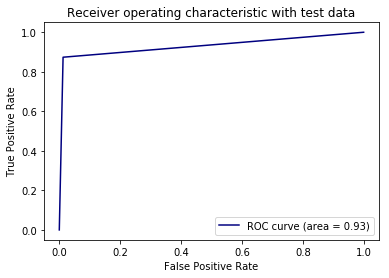

In [35]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

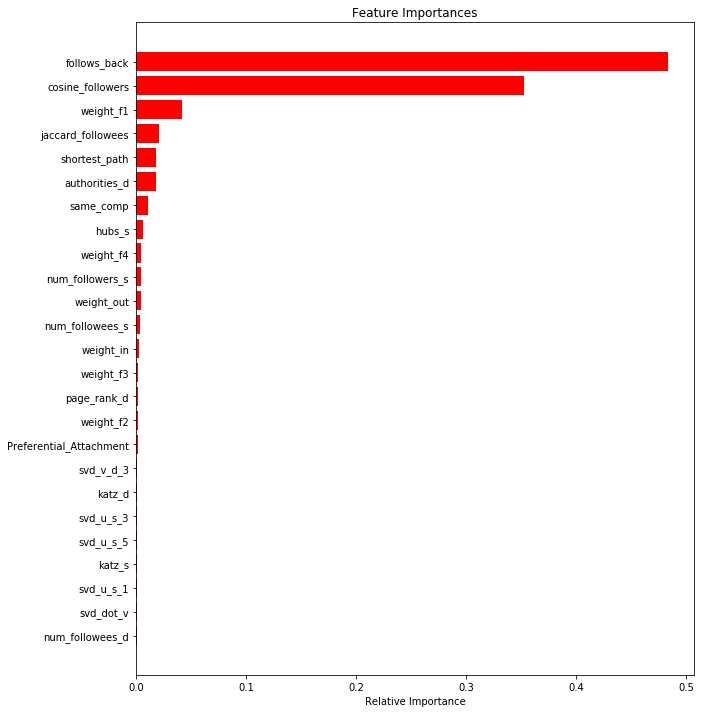

In [36]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# observation 

In [38]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','14','0.9640','0.9264'])
x.add_row(['XGBoost','112','11','0.9951','0.9264'])
print(x)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     121      |     14    |     0.9640     |     0.9264    |
|    XGBoost    |     112      |     11    |     0.9951     |     0.9264    |
+---------------+--------------+-----------+----------------+---------------+
